# ProShares Replication

## HBS Case

### *ProShares Hedge Replication ETF*

***

# Section 2:  Analyzing the Data

Use the data found on Canvas, in <b>'proshares analysis data.xlsx'</b>. 

It has monthly data on financial indexes and ETFs from `Aug 2011` through `May 2025`.

-----

## Question 2.1 

For the series in the "hedge fund series" tab, report the following summary statistics:

(a) mean

(b) volatility

(c) Sharpe ratio

Annualize these statistics.

In [1]:
# Question 2.1 (a) Code Here
import pandas as pd
import numpy as np

FILE_PATH = "../data/proshares_analysis_data.xlsx"
SHEET = "hedge_fund_series"

# Set first column as a Date index
df = pd.read_excel(FILE_PATH, sheet_name = SHEET)
df = df.rename(columns = {df.columns[0]: "Date"}).set_index("Date")
bench_df = pd.read_excel("../data/proshares_analysis_data.xlsx", sheet_name = 'merrill_factors', index_col = 0)

# Annualise mean (monthly returns * 12)
annualised_mean = df.astype(float).mean() * 12

print(annualised_mean.round(4))

HFRIFWI Index     0.0513
MLEIFCTR Index    0.0385
MLEIFCTX Index    0.0365
HDG US Equity     0.0269
QAI US Equity     0.0288
dtype: float64


In [2]:
# Question 2.1 (b) Code Here
# Annualise volatility (monthly std * sqrt(12))
annualised_vol = df.astype(float).std(ddof=1) * np.sqrt(12)

print(annualised_vol.round(4))

HFRIFWI Index     0.0588
MLEIFCTR Index    0.0552
MLEIFCTX Index    0.0551
HDG US Equity     0.0574
QAI US Equity     0.0498
dtype: float64


In [3]:
# Question 2.1 (c) Code Here
annualised_sharpe = annualised_mean / annualised_vol

print(annualised_sharpe.round(4))

HFRIFWI Index     0.8722
MLEIFCTR Index    0.6976
MLEIFCTX Index    0.6629
HDG US Equity     0.4684
QAI US Equity     0.5783
dtype: float64


-----

## Question 2.2

For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk:

(a) Skewness

(b) Excess Kurtosis (in excess of 3)

(c) VaR (.05) - the fifth quantile of historic returns

(d) CVaR (.05) - the mean of the returns at or below the fifth quantile

(e) Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [4]:
# Question 2.2 (a) Code Here
skewness = df.astype(float).skew()

print(skewness.round(4))

HFRIFWI Index    -0.9483
MLEIFCTR Index   -0.2900
MLEIFCTX Index   -0.2735
HDG US Equity    -0.2749
QAI US Equity    -0.4335
dtype: float64


In [5]:
# Question 2.2 (b) Code Here
excess_kurtosis = df.astype(float).kurt()

print(excess_kurtosis.round(4))

HFRIFWI Index     5.6574
MLEIFCTR Index    1.6309
MLEIFCTX Index    1.5898
HDG US Equity     1.7765
QAI US Equity     1.4492
dtype: float64


In [6]:
# Question 2.2 (c) Code Here
var_05 = df.astype(float).quantile(0.05)

print(var_05.round(4))

HFRIFWI Index    -0.0240
MLEIFCTR Index   -0.0270
MLEIFCTX Index   -0.0270
HDG US Equity    -0.0299
QAI US Equity    -0.0172
Name: 0.05, dtype: float64


In [7]:
# Question 2.2 (d) Code Here
cvar_05 = df.astype(float).apply(lambda x: x[x <= x.quantile(0.05)].mean())

print(cvar_05.round(4))

HFRIFWI Index    -0.0360
MLEIFCTR Index   -0.0350
MLEIFCTX Index   -0.0349
HDG US Equity    -0.0368
QAI US Equity    -0.0310
dtype: float64


In [8]:
# Question 2.2
skewness                    =   df.skew(numeric_only=True)
kurtosis                    =   df.kurtosis(numeric_only=True)-3
value_at_risk               =   df.quantile(q=0.2, numeric_only=True)
conditional_value_at_risk   =   df.apply(lambda s: s[s <= s.quantile(q=0.2)].mean(), axis=0)

acumulated_returns = (1 + df).cumprod()
current_peak = acumulated_returns.cummax()
drawdown = acumulated_returns / current_peak - 1.0      # same shape as df

rows = {}
for col in df.columns:
    dd = drawdown[col]
    w  = acumulated_returns[col]
    rp = current_peak[col]

    if dd.isna().all():
        rows[col] = [pd.NaT, pd.NaT, pd.NaT, np.nan]
        continue

    trough_date = dd.idxmin()                     # date of max drawdown (most negative)
    peak_val    = rp.loc[trough_date]             # level of the prior peak
    peak_date   = rp.loc[:trough_date].idxmax()   # first time that peak was set

    # first date on/after trough when wealth >= prior peak (may be never)
    rec_mask = w.loc[trough_date:].ge(peak_val)
    recovery_date = rec_mask.idxmax() if rec_mask.any() else pd.NaT

    rows[col] = [peak_date, trough_date, recovery_date, dd.min()]

summary = pd.DataFrame.from_dict(
    rows, orient="index",
    columns=["peak_date", "trough_date", "recovery_date", "max_drawdown"]
)

results = pd.DataFrame({
    "Skewness":        skewness,
    "Kurtosis":        kurtosis,
    "VaR":             value_at_risk, 
    "CVaR":            conditional_value_at_risk
}).round(4)

results.head(10)

,Skewness,Kurtosis,VaR,CVaR
HFRIFWI Index,-0.9483,2.6574,-0.0061,-0.0188
MLEIFCTR Index,-0.2900,-1.3691,-0.0061,-0.0198
MLEIFCTX Index,-0.2735,-1.4102,-0.0062,-0.0200
HDG US Equity,-0.2749,-1.2235,-0.0084,-0.0215
QAI US Equity,-0.4335,-1.5508,-0.0082,-0.0176


In [9]:
# 2.2 (e)
summary.head(10)

,peak_date,trough_date,recovery_date,max_drawdown
HFRIFWI Index,2019-12-31,2020-03-31,2020-08-31,-0.115473
MLEIFCTR Index,2021-06-30,2022-09-30,2024-02-29,-0.124302
MLEIFCTX Index,2021-06-30,2022-09-30,2024-02-29,-0.124388
HDG US Equity,2021-06-30,2022-09-30,2024-07-31,-0.140720
QAI US Equity,2021-06-30,2022-09-30,2024-02-29,-0.137716


-----

## Question 2.3

For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics:

(a) Market Beta

(b) Treynor Ratio

(c) Information ratio

Annualize these three statistics as appropriate.

In [10]:
# 2.3 (a-c)
import statsmodels.api as sm

Ticks = list(df.columns)

frequency = 12
Beta_dic = {}
Treynor_dic = {}
Info_dic = {}
Alpha_dic = {}
for tick in Ticks:
    X = bench_df['SPY US Equity']
    X = sm.add_constant(X)
    y = df[tick]
    X = X.loc[ X.notnull().all(axis = 1) & y.notnull()]
    y = y.loc[ X.notnull().all(axis = 1) & y.notnull()]
    model = sm.OLS(y, X)
    result = model.fit()
    Treynor_num = y.mean()/ result.params['SPY US Equity'] * frequency
    Alpha_num = result.params['const'] * frequency
    Beta_num = result.params['SPY US Equity']
    Info_num = result.params['const'] / result.resid.std() * np.sqrt(frequency)
    Beta_dic[tick] = Beta_num
    Treynor_dic[tick] = Treynor_num
    Info_dic[tick] = Info_num
    Alpha_dic[tick] = Alpha_num

#Ratio_Table = pd.DataFrame.from_dict([Beta_dic, Treynor_dic, Info_dic], orient= 'index', columns= ["Market Beta", "Treynor Ratio", "Information Ratio"])
Ratio_Table = pd.DataFrame.from_dict({"Alpha" : Alpha_dic ,"Market Beta": Beta_dic, "Treynor Ratio":Treynor_dic, "Information Ratio": Info_dic})
Ratio_Table.head(10)

,Alpha,Market Beta,Treynor Ratio,Information Ratio
HFRIFWI Index,0.001733,0.346312,0.148072,0.055336
MLEIFCTR Index,-0.011037,0.342487,0.112514,-0.436440
MLEIFCTX Index,-0.012900,0.341483,0.106963,-0.510548
HDG US Equity,-0.023866,0.350602,0.076669,-0.862386
QAI US Equity,-0.014815,0.301413,0.095587,-0.597796


-----

## Question 2.4

Discuss the previous statistics, and what they tell us about...

(a) the differences between SPY and the hedge-fund series?

(b) which performs better between HDG and QAI.

(c) whether HDG and the ML series capture the most notable properties of HFRI.

### Question 2.4 (a) Answer

The hedge-fund series provide much lower market exposure. The beta related to all of them is between 0.30 and 0.35. Also, The R-squared indicates that not all of their movements are explained by the market.

Also, all of the funds have underperformed the SPY as a bechmark over the sample given that all of the alphas are negative with the expection of HRFI. In that sense, the information ratio confirms this as they are also negative for each one of the funds. 

### Question 2.4 (b) Answer

QAI seems to have a better performance than HDG. It has higher Treynor and information ratio, whihc indicated better returns per unit of risk. In addition, it has a lower beta which indicates less exposure to systematic risk.
QAI did have a worse _worst_ daily drawdown, but among the bottom 5\% of returns it averaged a lower one.

### Question 2.4 (c) Answer

They do not replicate HFRI's most notable properties. On one hand, they provide similar market exposure as the betas are very similar. On the other hand, they lag HFRI in performance metrics as the Treynor and informaiton ratios. The most striking difference beting the positive alpha achieved, versus negative alphas for other funds.

-----

## Question 2.5 

Report the correlation matrix for these assets.

(a) Show the correlations as a heat map.

(b) Which series have the highest and lowest correlations?


Greatest Positive Correlation: MLEIFCTR Index & MLEIFCTX Index (1.000)
Greatest Negative Correlation:  HFRIFWI Index & QAI US Equity (0.858)
Least Correlated Pair: HFRIFWI Index & QAI US Equity (0.858)


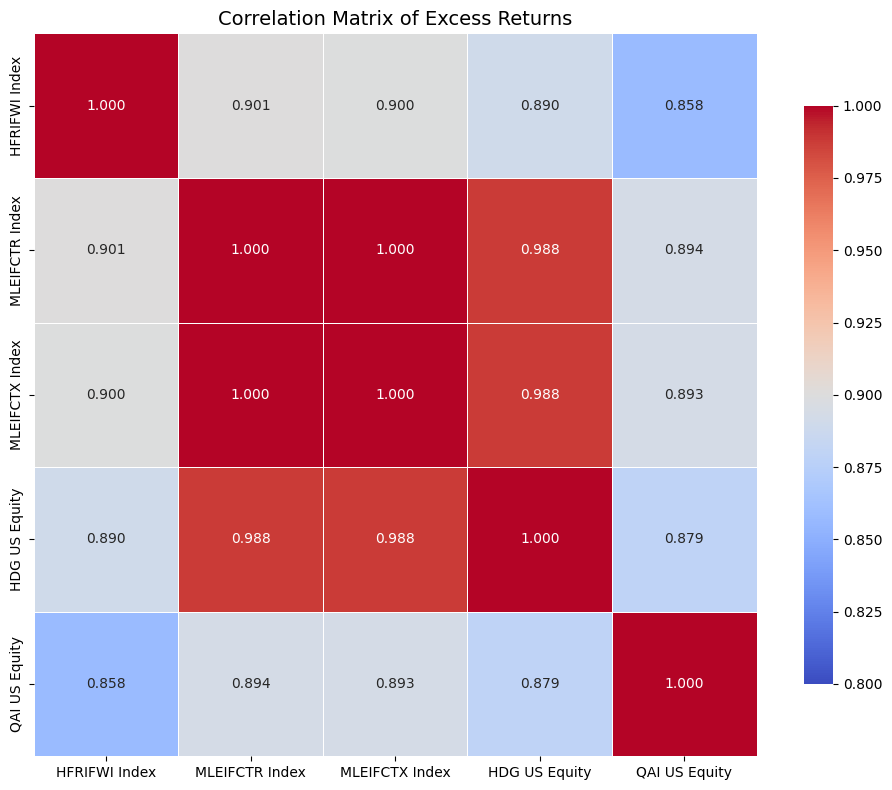

In [11]:
# Question 2.5 (a-b)
import matplotlib.pyplot as plt
import seaborn as sns

#from HW1
# Correlation matrix of monthly excess returns
corr_matrix = df.corr()

# Round for readability
corr_matrix_rounded = corr_matrix.round(3)

# Find highest and lowest correlation
# Stack the matrix into pairs, dropping self-correlations
corr_pairs = corr_matrix.stack().reset_index()
corr_pairs.columns = ["Asset1", "Asset2", "Correlation"]

# Keep only unique pairs
corr_pairs = corr_pairs[corr_pairs["Asset1"] < corr_pairs["Asset2"]]

# Identify max and min correlation pairs
max_corr = corr_pairs.loc[corr_pairs["Correlation"].idxmax()]
min_corr = corr_pairs.loc[corr_pairs["Correlation"].idxmin()]

# display
print(f"\nGreatest Positive Correlation: {max_corr['Asset1']} & {max_corr['Asset2']} ({max_corr['Correlation']:.3f})")
print(f"Greatest Negative Correlation:  {min_corr['Asset1']} & {min_corr['Asset2']} ({min_corr['Correlation']:.3f})")

# Find pair with correlation closest to zero
min_abs_corr = corr_pairs.iloc[(corr_pairs['Correlation'].abs()).argmin()]
print(f"Least Correlated Pair: {min_abs_corr['Asset1']} & {min_abs_corr['Asset2']} ({min_abs_corr['Correlation']:.3f})")

# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True, fmt=".3f",
    cmap="coolwarm", center=0.9, vmin=0.8, vmax=1,
    square=True, linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax
)
ax.set_title("Correlation Matrix of Excess Returns", fontsize=14)
plt.tight_layout()
plt.show()

-----

## Question 2.6  

Replicate HFRI with the six factors listed on the "merrill factors" tab. Include a constant, and run the unrestricted regression,  

$$
\begin{aligned}
r_t^{\mathrm{HFRI}} &= \alpha^{\mathrm{merr}} + x_t^{\mathrm{merr}}\beta^{\mathrm{merr}} + \epsilon_t^{\mathrm{merr}} \\[6pt]
\hat r_t^{\mathrm{HFRI}} &= \hat\alpha^{\mathrm{merr}} + x_t^{\mathrm{merr}}\hat\beta^{\mathrm{merr}}
\end{aligned}
$$  

Note that the second equation is just our notation for the fitted replication.  

(a) Report the intercept and betas.  

(b) Are the betas realistic position sizes, or do they require huge long-short positions?  

(c) Report the R-squared.  

(d) Report the volatility of $\epsilon^{\mathrm{merr}}$, the tracking error.  


In [12]:
# Question 2.6 (a-d)
target_col  = "HFRIFWI Index"
factor_cols = ["USGG3M Index","SPY US Equity","IWM US Equity",
               "EUO US Equity","EFA US Equity","EEM US Equity"]

# Align data
replication_df = bench_df[factor_cols].join(df[[target_col]], how="inner")

# OLS with intercept
y = replication_df[target_col]
X = sm.add_constant(replication_df[factor_cols])
model = sm.OLS(y, X, missing="drop").fit()

# (a) Intercept and betas
alpha = model.params["const"]
betas = model.params.drop("const").rename("beta")

betas_table = betas.to_frame()
betas_table.loc["(Intercept)","beta"] = alpha

# (b)
gross_exposure = betas.abs().sum() 
max_abs_beta   = betas.abs().max()
realism_flags  = pd.Series({
    "gross_exposure": gross_exposure,
    "max_abs_beta":   max_abs_beta
})

# (c) R-squared
r2 = model.rsquared

# (d) Tracking error (volatility of residuals)
resid = model.resid.dropna()
te_monthly = resid.std(ddof=1)
te_annual  = np.sqrt(12) * te_monthly

# Fitted replication series
replicated = model.fittedvalues.rename("hfri_replication")

# outputs
print("(a) Intercept and Betas")
print(betas_table)

print("\n(b) Position Size Checks")
print(realism_flags)

print("\n(c) R-squared")
print(f"R^2 = {r2:.4f}")

print("\n(d) Tracking Error (Residual Volatility)")
print(f"Monthly TE  = {te_monthly:.6f}")
print(f"Annual  TE  = {te_annual:.6f}")

# summary
summary = pd.DataFrame({
    "alpha": [alpha],
    "R2": [r2],
    "TE_monthly": [te_monthly],
    "TE_annual": [te_annual],
    "gross_exposure": [gross_exposure],
    "max_abs_beta": [max_abs_beta]
}, index=[target_col])
print("\nSummary")
print(summary)

(a) Intercept and Betas
                   beta
USGG3M Index   0.324931
SPY US Equity  0.043503
IWM US Equity  0.145824
EUO US Equity  0.029614
EFA US Equity  0.073994
EEM US Equity  0.085564
(Intercept)    0.001149

(b) Position Size Checks
gross_exposure    0.703430
max_abs_beta      0.324931
dtype: float64

(c) R-squared
R^2 = 0.8427

(d) Tracking Error (Residual Volatility)
Monthly TE  = 0.006732
Annual  TE  = 0.023320

Summary
                  alpha        R2  TE_monthly  TE_annual  gross_exposure  \
HFRIFWI Index  0.001149  0.842694    0.006732    0.02332         0.70343   

               max_abs_beta  
HFRIFWI Index      0.324931  


-----

## Question 2.7  

Let's examine the replication out-of-sample (OOS).  

Starting with $t = 61$ month of the sample, do the following:  

(a) Use the previous 60 months of data to estimate the regression equation.  
This gives time-t estimates of the regression parameters, $\tilde{\alpha}^{\mathrm{merr}}_{t}$ and $\tilde{\beta}^{\mathrm{merr}}_{t}$.  

(b) Use the estimated regression parameters, along with the time-t regressor values, $x^{\mathrm{merr}}_{t}$, calculate the time-t replication value that is, with respect to the regression estimate, built "out-of-sample" (OOS).  

$$
\hat r_t^{\mathrm{HFRI}} \equiv \tilde{\alpha}^{\mathrm{merr}} + (x_t^{\mathrm{merr}})^\prime \tilde{\beta}^{\mathrm{merr}}
$$  

(c) Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.  

(d) How well does the out-of-sample replication perform with respect to the target?  


In [13]:
SPY_SHEET = 'merrill_factors'

merrill_factors = pd.read_excel(FILE_PATH, sheet_name = SPY_SHEET)
merrill_factors = merrill_factors.rename(columns = {merrill_factors.columns[0]: "Date"}).set_index("Date")
spy = merrill_factors['SPY US Equity']
merrill_factors.head()

# Align all datasets to common dates
common_dates = df.index.intersection(merrill_factors.index)

# Extract aligned data
funds = df.loc[common_dates]
benchmark = spy.loc[common_dates]
factors = merrill_factors.loc[common_dates]

# Get OLS metrics for factor decomposition
# run regression on HFRI using Merrill factors
hfri_col = 'HFRIFWI Index'
hfri = funds[hfri_col]

# For each fund, combine with SPY and drop NAs for that specific pair
hfri_factors = pd.concat([hfri, factors], axis=1)

# Drop rows where either this fund OR SPY has NAs
clean_hfri_factors = hfri_factors.dropna()

In [14]:
# Question 2.7 (a) Code Here
start_time = 0
SAMPLE_SIZE = 60

# Run OLS regression: fund returns = alpha + beta^T * factors
X = sm.add_constant(clean_hfri_factors[factors.columns].iloc[start_time:(SAMPLE_SIZE)])
model = sm.OLS(clean_hfri_factors[hfri_col].iloc[start_time:SAMPLE_SIZE], X).fit()

print(f"\n{SAMPLE_SIZE}-day regression results:")
print(f"Alpha/intercept: {model.params['const']:.6f}")
print(f"R-squared: {model.rsquared:.6f}")
print(f"Number of observations: {model.nobs}")
for factor in factors.columns:
    print(f"{factor} beta: {model.params[factor]:.6f}")
    print("-" * 50)


60-day regression results:
Alpha/intercept: -0.000437
R-squared: 0.858827
Number of observations: 60.0
SPY US Equity beta: 0.088883
--------------------------------------------------
USGG3M Index beta: 10.177090
--------------------------------------------------
EEM US Equity beta: 0.049401
--------------------------------------------------
EFA US Equity beta: 0.120784
--------------------------------------------------
EUO US Equity beta: 0.023246
--------------------------------------------------
IWM US Equity beta: 0.073647
--------------------------------------------------


In [15]:
# Question 2.7 (b) Code Here
X_oos = clean_hfri_factors[factors.columns].iloc[SAMPLE_SIZE:SAMPLE_SIZE+1]
# Convert to numpy array and add constant manually
X_oos_array = X_oos.values  # Shape: (1, 6)
X_oos_with_const = np.column_stack([np.ones(X_oos_array.shape[0]), X_oos_array])  # Shape: (1, 7)
r_t_plus_1 = model.predict(X_oos_with_const)
print(r_t_plus_1)

[0.00496643]


In [16]:
# Question 2.7 (c) Code Here
predictions = []
SAMPLE_SIZE = 60

for start_time in range(1, len(clean_hfri_factors) - SAMPLE_SIZE):

    # Run OLS regression: fund returns = alpha + beta^T * factors
    X = sm.add_constant(clean_hfri_factors[factors.columns].iloc[start_time:(start_time+SAMPLE_SIZE)])
    model = sm.OLS(clean_hfri_factors[hfri_col].iloc[start_time:(start_time+SAMPLE_SIZE)], X).fit()

    X_oos = clean_hfri_factors[factors.columns].iloc[start_time+SAMPLE_SIZE:start_time+SAMPLE_SIZE+1]
    # Convert to numpy array and add constant manually
    X_oos_array = X_oos.values  # Shape: (1, 6)
    X_oos_with_const = np.column_stack([np.ones(X_oos_array.shape[0]), X_oos_array])  # Shape: (1, 7)
    r_t_plus_1 = model.predict(X_oos_with_const)
    predictions.append(r_t_plus_1)

In [17]:
# Question 2.7 (d) Code Here
# Calculate residuals (actual - predicted)
actual_returns = clean_hfri_factors[hfri_col].iloc[SAMPLE_SIZE+1:]  # Actual HFRI returns
predicted_returns = np.array(predictions).flatten()  # Your predictions
residuals = actual_returns - predicted_returns

# Tracking error (annualized)
tracking_error = residuals.std() * np.sqrt(12)
print(f"Tracking Error (Annualized): {tracking_error:.4f}")
# Information ratio = (Excess Return) / (Tracking Error)
excess_return = (actual_returns - predicted_returns).mean() * 12  # Annualized
information_ratio = excess_return / tracking_error
print(f"Information Ratio: {information_ratio:.4f}")
# OOS R-squared
ss_res = np.sum((actual_returns - predicted_returns) ** 2)
ss_tot = np.sum((actual_returns - actual_returns.mean()) ** 2)
oos_r_squared = 1 - (ss_res / ss_tot)
print(f"Out-of-Sample R-squared: {oos_r_squared:.4f}")
mae = np.mean(np.abs(actual_returns - predicted_returns))
print(f"Mean Absolute Error: {mae:.4f}")

Tracking Error (Annualized): 0.0276
Information Ratio: 0.5959
Out-of-Sample R-squared: 0.8055
Mean Absolute Error: 0.0057


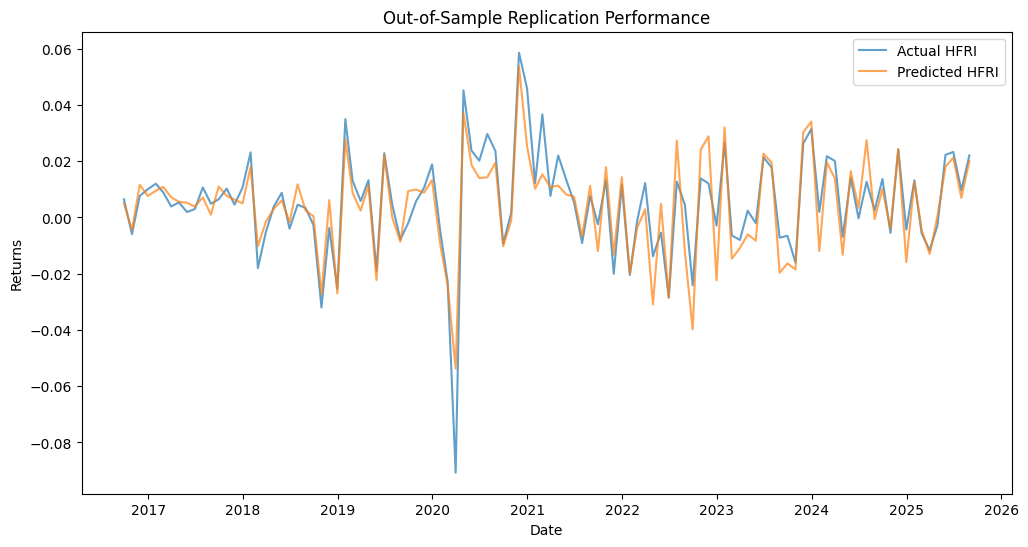

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_returns.index, actual_returns, label='Actual HFRI', alpha=0.7)
plt.plot(actual_returns.index, predicted_returns, label='Predicted HFRI', alpha=0.7)
plt.title('Out-of-Sample Replication Performance')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

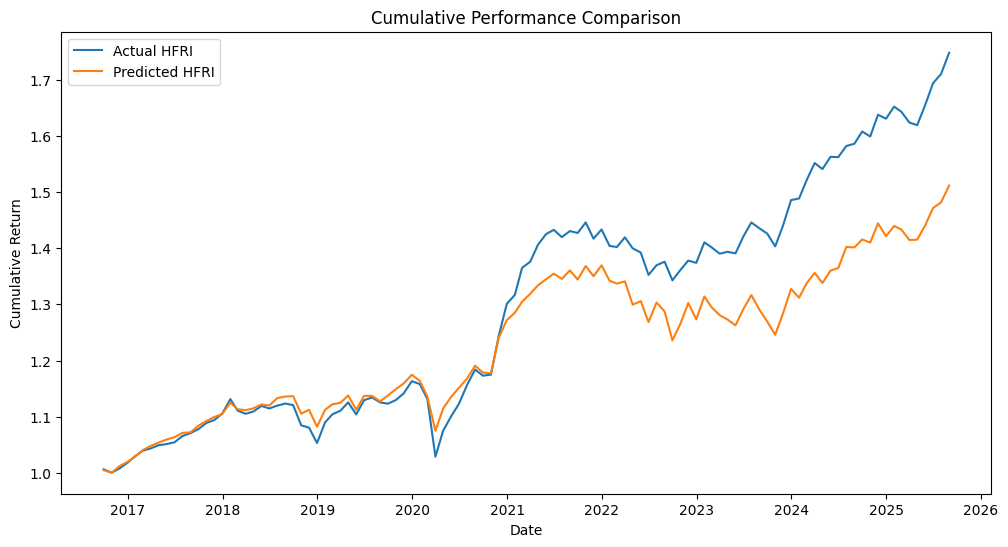

In [19]:
# Cumulative returns
cumulative_actual = (1 + actual_returns).cumprod()
cumulative_predicted = (1 + predicted_returns).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_actual.index, cumulative_actual, label='Actual HFRI')
plt.plot(cumulative_actual.index, cumulative_predicted, label='Predicted HFRI')
plt.title('Cumulative Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

The out of sample replication seems to perform well. Over time, however, differences compound such that cumulative returns are predicted to be more than 20 pp below actual performance.